In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score, KFold

In [2]:
glogs_final = pd.read_csv('https://raw.githubusercontent.com/tmarchok1/DS440_project/refs/heads/main/glogs_final.csv')
glogs_final.head()

,date,year,week,day_of_week,v_name,h_name,day_night,park_id,temp,precip,capacity,prev_year_wins,made_playoffs,won_division,InstagramFollowers,CityPopulation,attendance
0,2005-04-03,2005,1,Sun,BOS,NYY,1,Old Yankee Stadium,51.7,0.587,56937.0,101,1,1,3900000,19940274,54818.0
1,2005-04-04,2005,1,Mon,OAK,BAL,0,Camden Yards,60.7,0.000,45971.0,78,0,0,746000,2859024,48271.0
2,2005-04-04,2005,1,Mon,CLE,CHW,0,US Cellular Field,56.2,0.000,40615.0,83,0,0,664000,9408576,38141.0
3,2005-04-04,2005,1,Mon,KC,DET,0,Comerica Park,59.0,0.000,41083.0,72,0,0,1000000,4400587,44105.0
4,2005-04-04,2005,1,Mon,MIN,SEA,0,Safeco Field,50.1,0.130,47943.0,63,0,0,927000,4145494,46249.0


In [3]:
# Create dummy model using only h_name variable
homedf = glogs_final.groupby('h_name')['attendance'].mean().sort_values().to_frame()
dummydf = pd.merge(glogs_final, homedf, on='h_name', how='left')
dummydf

# Evaluation metrics for dummy model
mse = mean_squared_error(dummydf['attendance_x'], dummydf['attendance_y'])
rmse = mse**(1/2)
r2 = r2_score(dummydf['attendance_x'], dummydf['attendance_y'])

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')

Mean Squared Error (MSE): 58894063.76
RMSE: 7674.25
R-squared Score (R²): 0.46


In [4]:
# Data preprocessing

# Drop columns
glogs_final = glogs_final.drop(columns=['date', 'year', 'temp'])

# Binary encode 'day_of_week' and 'precip'
glogs_final['day_of_week'] = glogs_final['day_of_week'].map({'Mon':0, 'Tue':0, 'Wed':0, 'Thu':0, 'Fri':1, 'Sat':1, 'Sun':1}).astype('int')
glogs_final['precip'] = glogs_final['precip'].map(lambda x: 1 if x != 0 else 0)
glogs_final

# Apply OneHotEncoder to 'v_name', 'h_name', 'park_id' columns
encoder = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(sparse_output=False), ['week', 'v_name', 'h_name', 'park_id'])],
    remainder='passthrough'  # Keep other columns if there are any
)

df_encoded = encoder.fit_transform(glogs_final)

# Rename columns
feature_names = encoder.get_feature_names_out()
feature_names = [name.replace("remainder__", "") for name in feature_names]

# Convert the result back to a DataFrame (optional)
df_encoded = pd.DataFrame(df_encoded, columns=feature_names)
df_encoded

,cat__week_1,cat__week_2,cat__week_3,cat__week_4,cat__week_5,cat__week_6,cat__week_7,cat__week_8,cat__week_9,cat__week_10,...,day_of_week,day_night,precip,capacity,prev_year_wins,made_playoffs,won_division,InstagramFollowers,CityPopulation,attendance
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,56937.0,101.0,1.0,1.0,3900000.0,19940274.0,54818.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,45971.0,78.0,0.0,0.0,746000.0,2859024.0,48271.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,40615.0,83.0,0.0,0.0,664000.0,9408576.0,38141.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,41083.0,72.0,0.0,0.0,1000000.0,4400587.0,44105.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,47943.0,63.0,0.0,0.0,927000.0,4145494.0,46249.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,50144.0,68.0,0.0,0.0,552000.0,3052498.0,27762.0
29031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,43651.0,63.0,0.0,0.0,1300000.0,6330422.0,36935.0
29032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,41915.0,84.0,0.0,0.0,1600000.0,4648486.0,41445.0
29033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,45494.0,100.0,1.0,1.0,1100000.0,2811927.0,44615.0


In [5]:
# Build random forest model - 9673 cases from 2005-2008
modeldata = df_encoded[:9673]

# Define features (X) and target variable (y)
X = modeldata.drop(columns=['attendance'])
y = modeldata['attendance']

# Split data into training / validation / test (80% train, 10% val, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Initialize the Random Forest regressor
model = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=None, min_samples_leaf=2, min_samples_split=5)
# Train the model
model.fit(X_train, y_train)

# Predict on the val set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared score (R²)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(1/2)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')

Mean Squared Error (MSE): 23970687.59
RMSE: 4895.99
R-squared Score (R²): 0.81


In [6]:
# Random Forest hyperparameter tuning
# Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
# Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Minimal, fast grid search
param_grid = {
    'n_estimators': [100],         # one value instead of 3
    'max_depth': [10],             # limit depth
    'min_samples_split': [5],      # one value
    'min_samples_leaf': [2]        # one value
}

# Use only 2-fold cross-validation for speed
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=2,
    scoring='neg_mean_squared_error'
)

# Run it
grid_search.fit(X_train, y_train)

# Print result
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [7]:
# Build random forest model - 21776 cases from 2005-2013
modeldata = df_encoded[:21776]

# Define features (X) and target variable (y)
X = modeldata.drop(columns=['attendance'])
y = modeldata['attendance']

# Split data into training / test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Initialize the Random Forest regressor
model = RandomForestRegressor(n_estimators=300, random_state=42, max_depth=None, min_samples_leaf=2, min_samples_split=5)


# Fit the model
model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = model.predict(X_train)

# Calculate training Mean Squared Error (MSE) and R-squared score (R²)
mse = mean_squared_error(y_train, y_train_pred)
rmse = mse**(1/2)
r2 = r2_score(y_train, y_train_pred)

print(f'Training Mean Squared Error (MSE): {mse:.2f}')
print(f'Training RMSE: {rmse:.2f}')
print(f'Training R-squared Score (R²): {r2:.2f}')



# Predict on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared score (R²)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(1/2)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')

Training Mean Squared Error (MSE): 11162361.04
Training RMSE: 3341.01
Training R-squared Score (R²): 0.90
Mean Squared Error (MSE): 23921382.29
RMSE: 4890.95
R-squared Score (R²): 0.79


In [8]:
# Build Lasso regression model

X = modeldata.drop(columns=["attendance"])
y = modeldata["attendance"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Lasso Regression
lasso = Lasso(alpha=0.1)  # Adjust alpha to control regularization strength
lasso.fit(X_scaled, y)

# Extract feature importance
feature_significance = pd.DataFrame({
    "Variable": X.columns,
    "Lasso_coef": lasso.coef_
})

# Rank features by absolute coefficient value
feature_significance["Abs_Coefficient"] = np.abs(feature_significance["Lasso_coef"])
feature_significance = feature_significance.sort_values(by="Abs_Coefficient", ascending=False)

# Display ranked features
feature_significance[["Variable", "Lasso_coef"]].head(10)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.330e+11, tolerance: 2.481e+08
  model = cd_fast.enet_coordinate_descent(


,Variable,Lasso_coef
72,cat__h_name_NYY,2790.072059
120,day_of_week,2669.071161
67,cat__h_name_LAD,2574.016546
68,cat__h_name_MIA,-2350.715381
80,cat__h_name_TB,-2210.103627
124,prev_year_wins,2064.889531
73,cat__h_name_OAK,-1938.678696
79,cat__h_name_STL,1523.188132
103,cat__park_id_Minute Maid Park,1464.709543
58,cat__h_name_CHC,1427.366809


In [9]:
# Cross validation for Lasso model
lasso_cv = LassoCV(cv=5).fit(X_scaled, y)
print(f"Optimal alpha: {lasso_cv.alpha_}")

Optimal alpha: 57.839247251260645


In [10]:
# Build Lasso for making predictions
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train Lasso Regression model
lasso = Lasso(alpha=31.640845472570195)
lasso.fit(X_train, y_train)

# Predict on test data
y_pred = lasso.predict(X_test)



lasso_predictions = pd.DataFrame({'Actual':y_test, 'Predictions':y_pred})
lasso_predictions.head()

,Actual,Predictions
9352,21107.0,21002.361363
20640,36590.0,37749.284679
10429,30262.0,27141.231195
21621,30636.0,29003.284402
1503,28971.0,29834.321874


In [11]:
# Evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(1/2)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f'RMSE: {rmse:.2f}')
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 36430498.7093
RMSE: 6035.77
R² Score: 0.6745


In [12]:
# Convert predictions and actuals to DataFrames with matching indices
train_results = pd.DataFrame({
    'actual': y_train,
    'predicted': y_train_pred
}, index=y_train.index)

test_results = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred
}, index=y_test.index)


# Combine results
results_df = pd.concat([train_results, test_results]).sort_index().reset_index()
results_df

,index,actual,predicted
0,0,54818.0,53291.284821
1,1,48271.0,38243.313565
2,2,38141.0,27919.193627
3,3,44105.0,28185.990208
4,4,46249.0,37097.580950
...,...,...,...
21771,21771,28315.0,25845.383170
21772,21772,41891.0,32965.223962
21773,21773,41495.0,41686.777405
21774,21774,44808.0,49120.825776


In [13]:
# Error analysis
modeldata = df_encoded[:21776].reset_index()

errordata = pd.merge(pd.merge(modeldata, glogs_final[['h_name', 'park_id']].reset_index(), how='left', on='index'), results_df, how='left', on='index').drop(columns=['index', 'attendance'])

errordata['residual'] = errordata['actual'] - errordata['predicted']
errordata['absresidual'] = np.sqrt(np.square(errordata['residual']))
errordata

,cat__week_1,cat__week_2,cat__week_3,cat__week_4,cat__week_5,cat__week_6,cat__week_7,cat__week_8,cat__week_9,cat__week_10,...,made_playoffs,won_division,InstagramFollowers,CityPopulation,h_name,park_id,actual,predicted,residual,absresidual
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,3900000.0,19940274.0,NYY,Old Yankee Stadium,54818.0,53291.284821,1526.715179,1526.715179
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,746000.0,2859024.0,BAL,Camden Yards,48271.0,38243.313565,10027.686435,10027.686435
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,664000.0,9408576.0,CHW,US Cellular Field,38141.0,27919.193627,10221.806373,10221.806373
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1000000.0,4400587.0,DET,Comerica Park,44105.0,28185.990208,15919.009792,15919.009792
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,927000.0,4145494.0,SEA,Safeco Field,46249.0,37097.580950,9151.419050,9151.419050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,783000.0,6457988.0,MIA,Marlins Park,28315.0,25845.383170,2469.616830,2469.616830
21772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1700000.0,19940274.0,NYM,Citi Field,41891.0,32965.223962,8925.776038,8925.776038
21773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1600000.0,4648486.0,SF,AT&T Park,41495.0,41686.777405,-191.777405,191.777405
21774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1100000.0,2811927.0,STL,Busch Stadium III,44808.0,49120.825776,-4312.825776,4312.825776


In [14]:
errordata[['h_name', 'residual', 'absresidual']].sort_values(by='absresidual', ascending=False).head(50)

#resids = errordata.groupby('h_name')['absresidual'].mean().sort_values().to_frame()

#resids.plot(kind='bar', y='absresidual')

,h_name,residual,absresidual
90,OAK,28378.641094,28378.641094
12187,TOR,27366.141893,27366.141893
4935,TOR,26890.355455,26890.355455
7268,BAL,25079.428264,25079.428264
88,CLE,23719.163109,23719.163109
2420,KC,23547.444232,23547.444232
6,ARI,23007.876521,23007.876521
9682,TOR,22911.404505,22911.404505
16930,CLE,22759.419207,22759.419207
19444,SEA,22370.670000,22370.670000


In [15]:
# Add absolute error
lasso_predictions['Error'] = abs(lasso_predictions['Actual'] - lasso_predictions['Predictions'])

# Sort by worst predictions
worst_preds = lasso_predictions.sort_values(by='Error', ascending=False)
worst_preds.head(20)


,Actual,Predictions,Error
90,44815.0,16436.358906,28378.641094
4935,50125.0,23234.644545,26890.355455
7268,46807.0,21727.571736,25079.428264
88,42461.0,18741.836891,23719.163109
2420,41054.0,17506.555768,23547.444232
6,45539.0,22531.123479,23007.876521
9682,48027.0,25115.595495,22911.404505
16930,43190.0,20430.580793,22759.419207
20568,45766.0,23817.174113,21948.825887
4894,38437.0,16675.189966,21761.810034


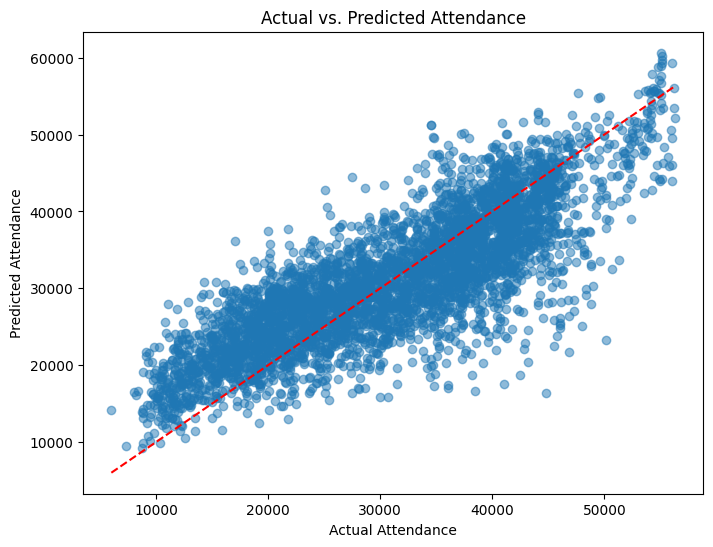

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(lasso_predictions['Actual'], lasso_predictions['Predictions'], alpha=0.5)
plt.plot([lasso_predictions['Actual'].min(), lasso_predictions['Actual'].max()],
         [lasso_predictions['Actual'].min(), lasso_predictions['Actual'].max()],
         'r--')
plt.xlabel('Actual Attendance')
plt.ylabel('Predicted Attendance')
plt.title('Actual vs. Predicted Attendance')
plt.show()


In [17]:
# This assumes you still have the test set's index or can realign rows
# If not, make sure you track test indices during train_test_split

merged = glogs_final.loc[y_test.index].copy()
merged['Prediction'] = y_pred
merged['Error'] = abs(merged['attendance'] - merged['Prediction'])  # use correct target name

merged.sort_values(by='Error', ascending=False).head(10)


,week,day_of_week,v_name,h_name,day_night,park_id,precip,capacity,prev_year_wins,made_playoffs,won_division,InstagramFollowers,CityPopulation,attendance,Prediction,Error
90,2,0,TOR,OAK,1,Coliseum,0,47170.0,91,0,0,530000,2463127,44815.0,16436.358906,28378.641094
4935,1,0,KC,TOR,1,Rogers Centre,1,49282.0,87,0,0,1700000,3026000,50125.0,23234.644545,26890.355455
7268,1,0,TB,BAL,0,Camden Yards,1,45971.0,69,0,0,746000,2859024,46807.0,21727.571736,25079.428264
88,2,0,CHW,CLE,0,Progressive Field,0,43000.0,80,0,0,726000,2171877,42461.0,18741.836891,23719.163109
2420,1,0,DET,KC,0,Kauffman Stadium,0,37903.0,56,0,0,1000000,2253579,41054.0,17506.555768,23547.444232
6,1,0,CHC,ARI,0,Chase Field,1,48686.0,51,0,0,665000,5186958,45539.0,22531.123479,23007.876521
9682,1,0,DET,TOR,1,Rogers Centre,1,49282.0,86,0,0,1700000,3026000,48027.0,25115.595495,22911.404505
16930,1,0,TOR,CLE,0,Progressive Field,0,43000.0,80,0,0,726000,2171877,43190.0,20430.580793,22759.419207
20568,12,0,DET,TOR,0,Rogers Centre,1,49282.0,73,0,0,1700000,3026000,45766.0,23817.174113,21948.825887
4894,1,1,TOR,TB,1,Tropicana Field,1,42735.0,61,0,0,528000,3424650,38437.0,16675.189966,21761.810034


In [18]:
# Average error by home team
merged.groupby('h_name')['Error'].mean().sort_values(ascending=False).head(10)

# Average error by day of week
merged.groupby('day_of_week')['Error'].mean().sort_values(ascending=False)


,Error
day_of_week,
0,4771.99854
1,4691.22886


In [19]:
# Residual = Actual - Predicted
residuals_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Residual': y_test - y_pred
})


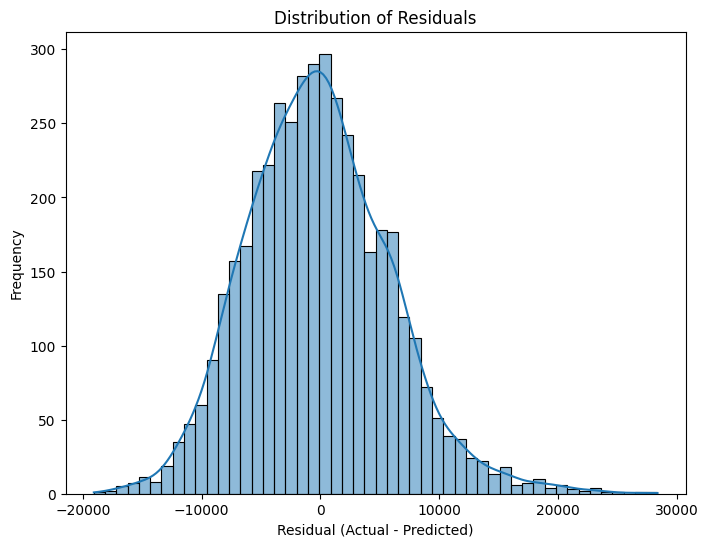

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.histplot(residuals_df['Residual'], bins=50, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

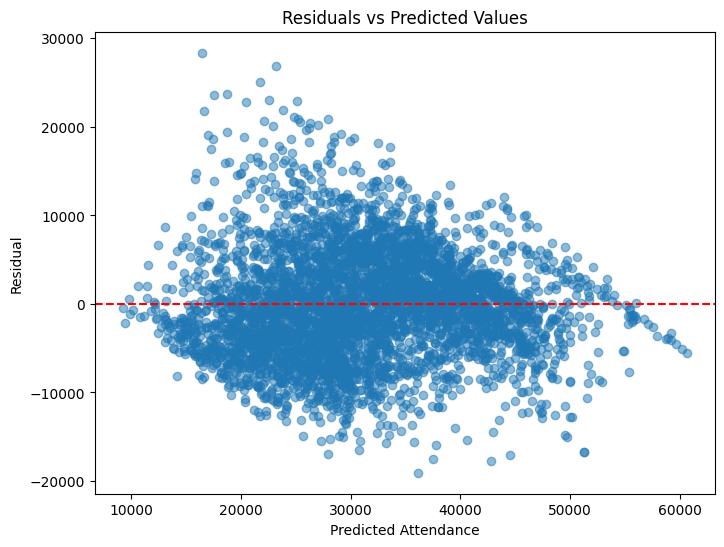

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(residuals_df['Predicted'], residuals_df['Residual'], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Attendance')
plt.ylabel('Residual')
plt.show()

In [22]:
# Make sure the index aligns — this assumes you're using train_test_split
residuals_full = glogs_final.loc[y_test.index].copy()
residuals_full['Residual'] = residuals_df['Residual'].values
residuals_full['Predicted'] = y_pred

In [23]:
residuals_full.groupby('h_name')['Residual'].mean().sort_values(ascending=False).head(10)


,Residual
h_name,
SEA,1225.916794
TEX,829.415610
SF,796.654902
HOU,730.891335
CLE,521.269208
DET,414.801391
PIT,347.297935
MIA,335.422554
LAA,285.233573


In [24]:
residuals_full.groupby('day_of_week')['Residual'].mean().sort_values(ascending=False)


,Residual
day_of_week,
0,-80.904750
1,-185.219864


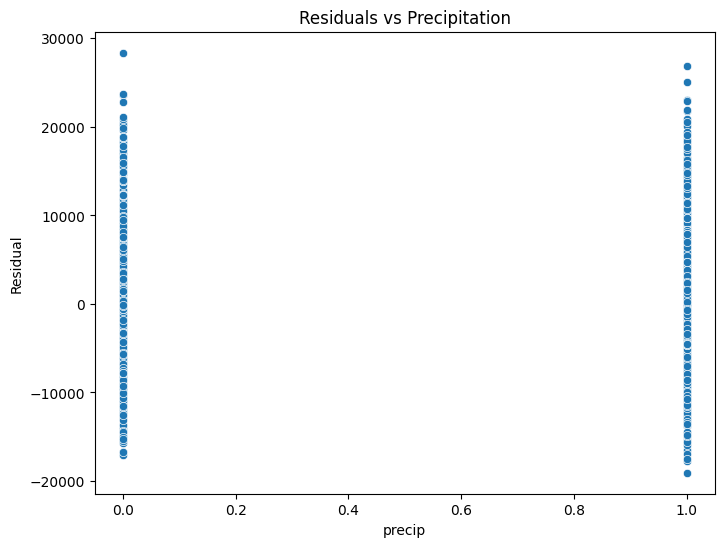

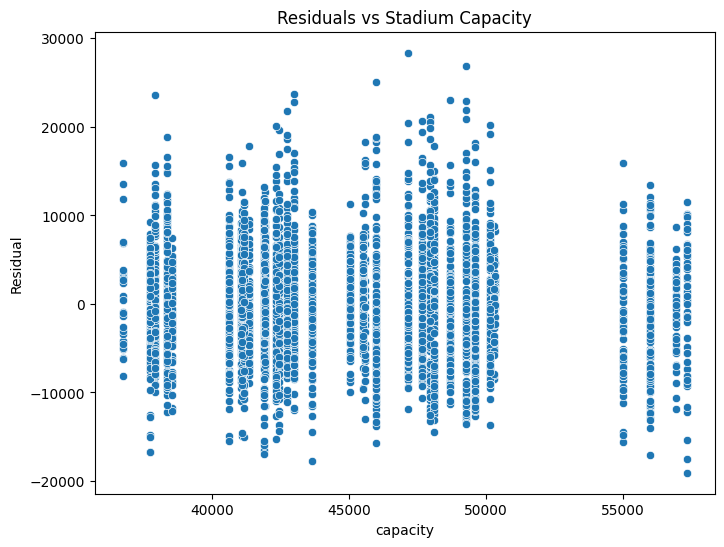

In [25]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='precip', y='Residual', data=residuals_full)
plt.title('Residuals vs Precipitation')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x='capacity', y='Residual', data=residuals_full)
plt.title('Residuals vs Stadium Capacity')
plt.show()